# Single Feature Importance

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from tqdm import tqdm
from IPython.display import display, HTML, Markdown
from glob import glob
from sklearn.model_selection import TimeSeriesSplit
from time import time

In /home/felsal/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/felsal/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/felsal/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/felsal/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/felsal/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

## Loading gtrends data

In [2]:
gtrends = pd.read_csv("data/gtrends.csv")
gtrends.loc[:, "date"] = pd.to_datetime(gtrends.date)
gtrends = gtrends.set_index("date")
words = list(gtrends.columns)
words.sort()
gtrends.head(3)

,BUY AND HOLD,DOW JONES,act,arts,bank,banking,blacklist,bonds,bubble,business,...,virginia,voters,votes,war,washington,water,william,wisconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,
2004-01-02,0.0,1.0,3.0,0.0,38.0,-1.0,1.0,-4.0,-2.0,20.0,...,8.0,0.0,0.0,5.0,20.0,2.0,4.0,0.0,14.0,11.0
2004-01-03,0.0,-1.0,-1.0,-3.0,-23.0,2.0,-1.0,0.0,3.0,-15.0,...,-6.0,0.0,0.0,10.0,-8.0,-8.0,-3.0,-2.0,-13.0,-16.0
2004-01-04,1.0,0.0,2.0,4.0,-10.0,0.0,-1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,9.0,-4.0,1.0,5.0,-5.0,6.0,10.0


## Loading and preprossesing market data

In [3]:
paths = glob("data/crsp/nyse/*csv")
paths.sort()
path = paths[832] 
name = path.split("/")[-1].split(".")[0]
target_name = name.replace(" ", "_") + "_return"
market = pd.read_csv(path)
market = market.drop([0,1],0)
market = market.rename(columns={"ticker":"date",
                                name:target_name})
market.loc[:, "date"] = pd.to_datetime(market.date)
market.loc[:, target_name] = market[target_name].astype("float")  / 100
market = market.set_index("date")
display(HTML(market.head(4).to_html()))
display(HTML(market.tail(4).to_html()))
print("shape = ", market.shape)

,CYN_US_Equity_return
date,
2000-01-03,-0.043643
2000-01-04,-0.033730
2000-01-05,0.018480
2000-01-06,0.018145


,CYN_US_Equity_return
date,
2015-10-27,0.001006
2015-10-28,0.002009
2015-10-29,0.001782
2015-10-30,-0.003670


shape =  (3983, 1)


In [4]:
market_train = market["2000":"2010"]
print("shape = ", market_train.shape)

shape =  (2767, 1)


## Naive Merging

In [5]:
merged = pd.merge_asof(market_train,gtrends,left_index=True, right_index=True)
merged = merged.dropna()
display(HTML(merged.head(4).to_html()))
print("shape = ", merged.shape)

,CYN_US_Equity_return,BUY AND HOLD,DOW JONES,act,arts,bank,banking,blacklist,bonds,bubble,business,buy,cancer,car,carolina,case,cash,ceo,chance,college,color,committee,community,companies,conflict,consume,consumption,corporation,council,county,court,crash,credit,crisis,culture,debt,default,democratic,derivatives,development,district,dividend,dow jones,earnings,economic,economics,economy,elected,election,elections,energy,environment,fed,federal,finance,financial,financial markets,fine,firm,fond,food,forex,founded,freedom,fun,gain,gains,garden,georgia,global,gold,government,governor,greed,growth,happy,headlines,health,hedge,holiday,home,house,housing,illinois,inc,industry,inflation,invest,investment,judge,justice,kentucky,kitchen,labor,law,legal,leverage,lifestyle,loss,ltd,management,market,marketing,markets,marriage,massachusetts,media,members,metals,million,minister,ministry,missouri,money,movement,movie,nasdaq,nyse,office,ohio,oil,opportunity,ore,party,pennsylvania,police,political,politics,portfolio,present,president,products,profit,project,rare earths,religion,representatives,republican,restaurant,return,returns,revenue,rich,rights,ring,risk,seats,secretary,security,sell,senate,served,service,services,short sell,short selling,social,society,stats,stock market,stocks,success,technology,tennessee,texas,tourism,trader,train,transaction,travel,unemployment,union,vermont,virginia,voters,votes,war,washington,water,william,wisconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-02,-0.000322,0.0,1.0,3.0,0.0,38.0,-1.0,1.0,-4.0,-2.0,20.0,-10.0,1.0,0.0,-6.0,-5.0,-1.0,1.0,-1.0,18.0,-2.0,-1.0,14.0,-3.0,1.0,0.0,0.0,6.0,2.0,30.0,13.0,0.0,14.0,0.0,2.0,0.0,1.0,0.0,0.0,7.0,10.0,0.0,2.0,0.0,1.0,-3.0,-1.0,0.0,-2.0,1.0,4.0,0.0,0.0,14.0,5.0,15.0,1.0,-2.0,4.0,1.0,-18.0,0.0,0.0,-6.0,-7.0,-2.0,2.0,-3.0,5.0,5.0,2.0,9.0,1.0,1.0,-1.0,-7.0,1.0,24.0,1.0,-6.0,1.0,10.0,2.0,16.0,7.0,6.0,1.0,0.0,3.0,-1.0,0.0,-1.0,-6.0,3.0,17.0,0.0,1.0,-1.0,1.0,3.0,11.0,1.0,4.0,0.0,5.0,0.0,-4.0,-1.0,1.0,-2.0,2.0,0.0,-2.0,2.0,2.0,-5.0,2.0,1.0,15.0,5.0,-2.0,0.0,0.0,-2.0,4.0,4.0,4.0,0.0,-4.0,0.0,3.0,10.0,0.0,3.0,0.0,-2.0,-1.0,-1.0,-13.0,-5.0,-2.0,5.0,1.0,3.0,-7.0,1.0,0.0,7.0,12.0,2.0,2.0,0.0,17.0,27.0,-1.0,1.0,5.0,2.0,-4.0,1.0,2.0,1.0,6.0,-2.0,11.0,-1.0,-5.0,-2.0,0.0,-4.0,2.0,10.0,-8.0,8.0,0.0,0.0,5.0,20.0,2.0,4.0,0.0,14.0,11.0
2004-01-05,0.003382,-1.0,0.0,3.0,3.0,-7.0,-3.0,0.0,-1.0,-3.0,1.0,-10.0,6.0,-2.0,-4.0,0.0,0.0,3.0,-1.0,32.0,7.0,1.0,38.0,1.0,-2.0,-1.0,2.0,-3.0,1.0,4.0,1.0,4.0,2.0,-1.0,2.0,1.0,-2.0,1.0,-2.0,0.0,27.0,0.0,1.0,2.0,1.0,2.0,-1.0,1.0,1.0,1.0,-7.0,2.0,-1.0,-4.0,0.0,1.0,2.0,-7.0,4.0,0.0,-4.0,-1.0,2.0,0.0,5.0,1.0,-1.0,-3.0,-8.0,-2.0,3.0,4.0,3.0,0.0,-2.0,-4.0,0.0,-1.0,1.0,0.0,-13.0,-7.0,0.0,-7.0,2.0,-2.0,3.0,0.0,2.0,2.0,-3.0,0.0,-4.0,-2.0,6.0,5.0,-1.0,0.0,1.0,-1.0,10.0,-3.0,4.0,0.0,15.0,-2.0,0.0,-1.0,-2.0,-1.0,0.0,3.0,0.0,0.0,3.0,-10.0,1.0,1.0,-8.0,-11.0,-1.0,1.0,1.0,-11.0,-5.0,-2.0,-3.0,3.0,1.0,-1.0,3.0,2.0,0.0,-3.0,0.0,0.0,0.0,1.0,-8.0,-2.0,1.0,-2.0,1.0,-2.0,2.0,-4.0,-2.0,-1.0,5.0,-4.0,0.0,1.0,-9.0,6.0,0.0,0.0,-4.0,1.0,-2.0,3.0,0.0,0.0,-3.0,-2.0,-4.0,4.0,4.0,-8.0,2.0,3.0,-6.0,-6.0,-4.0,1.0,1.0,1.0,4.0,-1.0,3.0,5.0,1.0,4.0,-15.0
2004-01-06,0.009790,0.0,1.0,10.0,1.0,37.0,5.0,0.0,-1.0,1.0,34.0,-5.0,4.0,-4.0,10.0,0.0,1.0,-1.0,0.0,-11.0,-2.0,5.0,-1.0,13.0,1.0,1.0,-4.0,27.0,8.0,25.0,20.0,-4.0,19.0,1.0,4.0,-1.0,2.0,-2.0,1.0,14.0,4.0,0.0,0.0,-2.0,4.0,2.0,3.0,-1.0,2.0,0.0,13.0,2.0,4.0,29.0,11.0,18.0,-2.0,2.0,-1.0,2.0,5.0,1.0,-1.0,-1.0,-6.0,-1.0,0.0,1.0,24.0,9.0,-10.0,11.0,1.0,0.0,5.0,2.0,0.0,40.0,0.0,7.0,0.0,6.0,1.0,14.0,26.0,7.0,-2.0,1.0,0.0,-1.0,4.0,2.0,-6.0,5.0,14.0,6.0,0.0,1.0,-2.0,6.0,23.0,10.0,8.0,2.0,-17.0,10.0,-1.0,1.0,2.0,1.0,-2.0,0.0,5.0,-2.0,-2.0,-28.0,0.0,0.0,46.0,33.0,4.0,-2.0,-1.0,6.0,13.0,5.0,5.0,-1.0,2.0,0.0,5.0,8.0,3.0,10.0,0.0,-2.0,2.0,1.0,17.0,-7.0,0.0,6.0,0.0,5.0,-13.0,8.0,1.0,12.0,17.0,0.0,4.

shape =  (1763, 183)


### Single Feature Importance

In [6]:
def single_feature_importance_cv(df,
                                 feature_name,
                                 target_name,
                                 n_splits):
    """
    Using a linear model and the cross-validation
    object 'TimeSeriesSplit', we calculate the R2 OOS for 
    "n_splits" test sets. The predictor is a simple linear
    model composed of the single feature 'feature_name'.
    
    The R2 is calculate using the formula in the paper
    
    "Empirical Asset Pricing via Machine
    Learning"
        
    :param df: data
    :type df: np.DataFrame
    :param feature_name: name of the feature column 'df'
    :type feature_name: str
    :param target_name: name of the target column 'df'
    :type target_name: str
    :param n_splits: number of cross-validation splits
    :type n_splits: int
    :return: array of R2 values for each OOS slit
    :rtype: np.array
    """
    r2_OOS = []
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(df):
        formula = "{} ~ {}".format(target_name, feature_name)
        df_train = df.iloc[train_index]
        df_test = df.iloc[test_index]
        lr = smf.ols(formula=formula, data=df_train).fit()
        y_pred = lr.predict(df_test).values
        y_true = df_test[target_name].values        
        erros =  y_true - y_pred
        num = (erros).dot(erros)
        dem = (y_true).dot(y_true)
        r2 = 1 - (num / dem)
        r2_OOS.append(r2)
    return np.array(r2_OOS)

## Add Shifting for all words

In [7]:
feature_dict = {}
merged_temp = merged.copy()
init = time()

for word in tqdm(words[:40]):
    new_features = []
    for shift in range(1, 31):
        new_feature = word.replace(" ", "_") + "_{}".format(shift)
        new_features.append(new_feature)
        merged_temp.loc[:, new_feature] = merged_temp[word].shift(shift)
    feature_dict[word]= new_features

time_shift = time() - init
time_shift = time_shift / 60
print("time to add all shifts for all words = {:.3f} (minutes)".format(time_shift))

100%|██████████| 40/40 [00:06<00:00,  5.89it/s]

time to add all shifts for all words = 0.113 (minutes)


## Calculating R2 OOS for different words

In [8]:
meta_results = []
n_splits = 5
init = time()

for word in tqdm(words[:40]):
    new_features = feature_dict[word]
    new_merged = merged_temp[[target_name] + new_features]

    results = []
    
    for new_feature in new_features:

        r2 = single_feature_importance_cv(df=new_merged,
                                          feature_name=new_feature,
                                          target_name=target_name,
                                          n_splits=n_splits)
        results.append((new_feature, np.mean(r2)))

    results = pd.DataFrame(results, columns=["feature", "mean_r2"])
    meta_results.append(results)
meta_results = pd.concat(meta_results)
meta_results = meta_results.sort_values("mean_r2",ascending=False).reset_index(drop=True)

time_analysis = time() - init
time_analysis = time_analysis / 60
print("time to analyze all shifts for all words = {:.3f} (minutes)".format(time_analysis))

100%|██████████| 40/40 [00:45<00:00,  1.13s/it]

time to analyze all shifts for all words = 0.753 (minutes)


In [9]:
meta_results.head(10)

,feature,mean_r2
0,derivatives_8,0.003046
1,conflict_15,0.002847
2,derivatives_28,0.002293
3,debt_20,0.002230
4,color_8,0.001757
5,banking_25,0.001713
6,cash_5,0.001674
7,cash_8,0.001629
8,ceo_18,0.001547
9,debt_25,0.001489


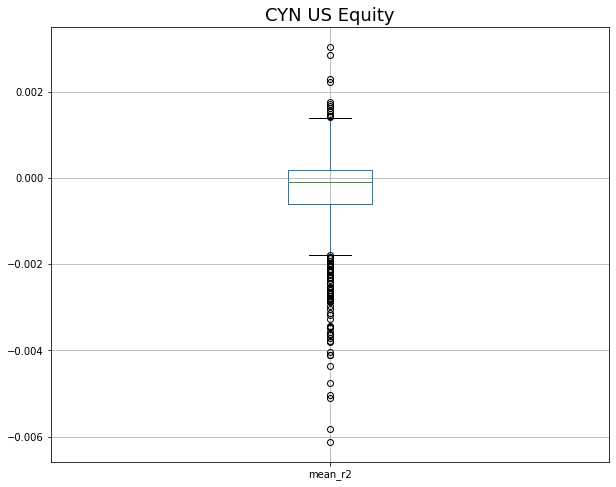

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
meta_results.boxplot(ax=ax);
ax.set_title(name, fontsize=18);

In [11]:
n = len(paths)

time1 = time_shift * n
time2 = time_analysis * n

final_time = (time1 + time2) / (60*60)

print("Estimated time to analize all ticker = {:.3f} (days)".format(final_time))

Estimated time to analize all ticker = 0.521 (days)
